In [4]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import scipy.sparse as ssp
import json
import networkx as nx
import json 
import seaborn as sns
from community import community_louvain 
import statsmodels.api as sm

import network_utils as ne

In [5]:
# Fix random seed for reproducibility 
random.seed(42)
np.random.seed(42)

SAVEFIG = False # saves generated figures to ./figure directory if TRUE
TITLEFONT = {'fontname': 'arial', 'size': 14}
LABELFONT = {'fontname': 'arial', 'size': 14}
LEGENDFONT = {'family': 'arial', 'size': 12}
TICKPARAM = {'family': 'arial', 'size': 12}

In [6]:
with pd.HDFStore('./data/gene_network_data.h5') as store:
    tec = store['TEC']
np_tec_abs = np.abs(tec.to_numpy(copy=True))

In [7]:
# Construct network
THRESHOLD = 0.75
tec_al = ne.threshold_weighted_adjacency_list(np_tec_abs, THRESHOLD)  
tec_graph_75 = ne.construct_network(tec_al, "TEC_75", tec.columns)

In [8]:
# generate a mapping between node name and node idx
idx2name = dict()
name2idx = dict()
for node_idx in tec_graph_75.nodes():
    curr_name = tec_graph_75.nodes[node_idx]['name']
    name2idx[curr_name] = node_idx     
    idx2name[node_idx] = curr_name     

#### Figure 3a: Protein abundance comparison between connected and isolated genes

In [9]:
# Get genes that are found in both protein abundance and RNA expression
found_genes = []
with open('./data/rna_prot_genes.txt') as f:
    for line in f:
        found_genes.append(line.strip('\n'))

In [10]:
top_connected = [] # genes with high connectivity
for node, degree in sorted(tec_graph_75.degree(weight="weight"), key=lambda x: x[1], reverse=True):
    if tec_graph_75.nodes[node]['name'] in found_genes and len(top_connected) != 1000: # first 1000
        top_connected.append(tec_graph_75.nodes[node]['name'])

connected_nodes = [] # used to obtain isolated genes
for node_idx in tec_graph_75.nodes:
    connected_nodes.append(tec_graph_75.nodes[node_idx]['name'])

isolated_nodes = [] # nodes (genes) with no connections
for node in tec.columns:
    if node not in connected_nodes and node in found_genes:
        isolated_nodes.append(node)
# randomly sample equal number of isolated nodes
isolated_nodes = random.sample(isolated_nodes, len(top_connected)) 

In [11]:
## test random
# sampled_random = random.sample(found_genes, 2000) # prevent overlapping
# top_connected = sampled_random[:1000]
# isolated_nodes = sampled_random[1000:]

In [12]:
abund_df = pd.read_csv('./data/protein_abundance.csv')

# filter data to contain genes of interest
connected_data = abund_df[abund_df['Gene name'].isin(top_connected)] 
isolated_data = abund_df[abund_df['Gene name'].isin(isolated_nodes)]

In [13]:
tissues = [
    'adrenal gland',
    'colon',
    'esophagus',
    'liver', 
    'heart muscle',
    'lung',
    'pancreas',
    'stomach',
    'testis',
] # tissues of interest
# we no longer need the names of the genes, only tissue and abundance value
connected_data = connected_data[connected_data['Tissue'].isin(tissues)].reset_index(drop=True)[['Tissue', 'Abundance']]
isolated_data = isolated_data[isolated_data['Tissue'].isin(tissues)].reset_index(drop=True)[['Tissue', 'Abundance']]

print("Data for highly connected genes: ", connected_data.shape)
print("Data for isolated genes: ", isolated_data.shape)

Data for highly connected genes:  (8707, 2)
Data for isolated genes:  (7730, 2)


In [14]:
# add label and concatenate 
isolated_data['Group'] = 'Isolated'
connected_data['Group'] = 'Highly Connected'
combined_data = pd.concat([isolated_data, connected_data])
combined_data = combined_data.reset_index(drop=True)

In [15]:
x_tick_labels  = [
    'adrenal\ngland',
    'colon',
    'esophagus',
    'liver', 
    'heart\nmuscle',
    'lung',
    'pancreas',
    'stomach',
    'testis',
]
x_tick_pos = [i for i in range(9)]

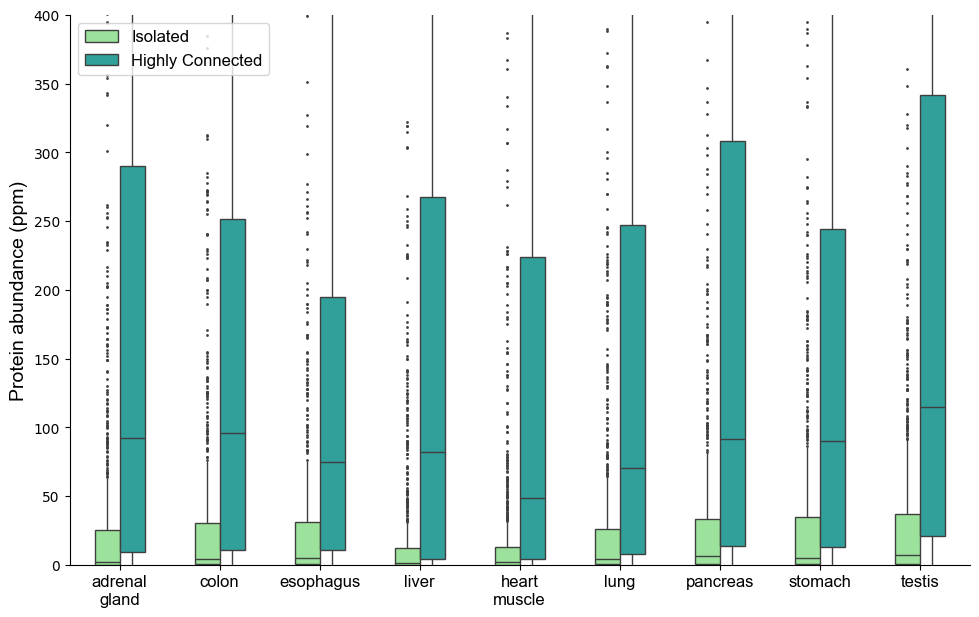

In [16]:
plt.figure(figsize=(9, 5.5))
custom_palette = {"Isolated": "lightgreen", "Highly Connected": "lightseagreen"}
ax = sns.boxplot(
    x="Tissue", 
    y="Abundance", 
    hue="Group", 
    data=combined_data,
    palette=custom_palette, 
    fliersize=1, 
    dodge=True, 
    width=0.5
)
# remove top and bottom whisker bar
for line in ax.lines: 
    xdata, ydata = line.get_xdata(), line.get_ydata()
    is_horizontal = ydata[0] == ydata[1] and xdata[0] != xdata[1]
    is_short = abs(xdata[1] - xdata[0]) < 0.2  
    if is_horizontal and is_short:
        line.set_visible(False)
        
plt.ylim(0, 400)
plt.legend(prop=LEGENDFONT)
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.xticks(ticks=x_tick_pos, labels=[])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig("./figures/figure3a.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xticks(x_tick_pos, x_tick_labels, rotation=0,**TICKPARAM)
    plt.xlabel('')
    plt.ylabel('Protein abundance (ppm)', **LABELFONT)
plt.show()

#### Figure 3b: Comparison of RNA expression level between connected and isolated genes

In [17]:
rna_co_df = pd.read_csv('./data/rna_tissue_hpa.tsv', sep='\t')
connected_data = rna_co_df[rna_co_df['Gene name'].isin(top_connected)]
isolated_data = rna_co_df[rna_co_df['Gene name'].isin(isolated_nodes)]

In [18]:
connected_data = connected_data[connected_data['Tissue'].isin(tissues) ].reset_index()[['Tissue', 'nTPM']]
isolated_data = isolated_data[isolated_data['Tissue'].isin(tissues) ].reset_index()[['Tissue', 'nTPM']]

print("Data for highly connected genes: ", connected_data.shape)
print("Data for isolated genes: ", isolated_data.shape)

isolated_data['Group'] = 'Isolated'
connected_data['Group'] = 'Highly Connected'
combined_data = pd.concat([isolated_data, connected_data])

Data for highly connected genes:  (9000, 2)
Data for isolated genes:  (9000, 2)


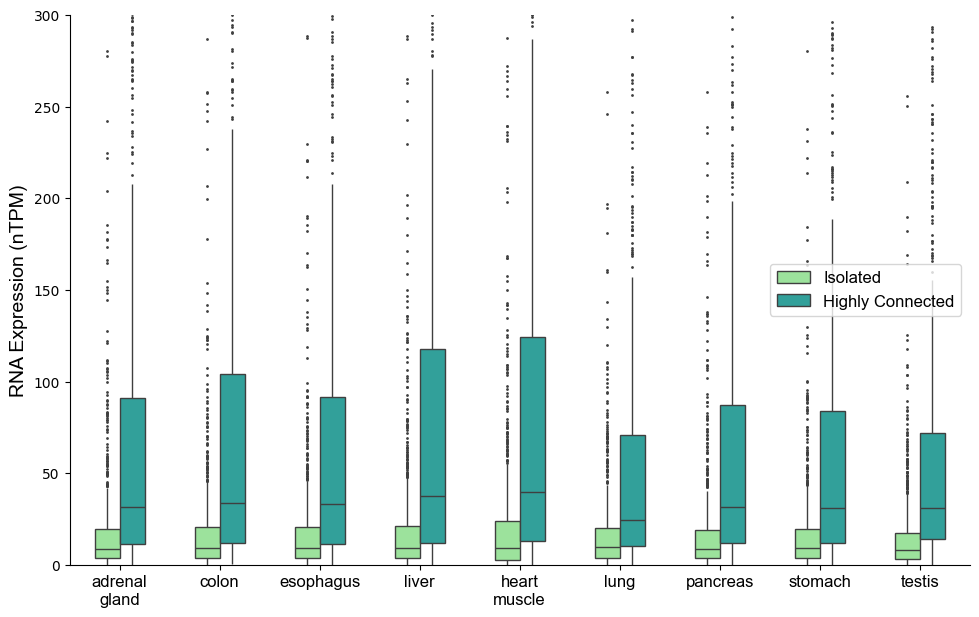

In [19]:
plt.figure(figsize=(9, 5.5))
ax = sns.boxplot(
    x="Tissue", 
    y="nTPM", 
    hue="Group", 
    data=combined_data,
    palette=custom_palette, 
    fliersize=1, 
    dodge=True, 
    width=0.5
)
# remove top and bottom whisker bar
for line in ax.lines: 
    xdata, ydata = line.get_xdata(), line.get_ydata()
    is_horizontal = ydata[0] == ydata[1] and xdata[0] != xdata[1]
    is_short = abs(xdata[1] - xdata[0]) < 0.2 
    if is_horizontal and is_short:
        line.set_visible(False)

plt.ylim(0, 300)
plt.legend(prop=LEGENDFONT)
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.xticks(ticks=x_tick_pos, labels=[])
    plt.xlabel('')
    plt.ylabel('')
    plt.savefig("./figures/figure3b.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xticks(x_tick_pos, x_tick_labels, rotation=0, **TICKPARAM)
    plt.xlabel('')
    plt.ylabel('RNA Expression (nTPM)', **LABELFONT)
plt.show()

#### Figure 3c: Comparison of protein abundance coefficient of variation between connected and isolated genes

In [20]:
# get genes that are found in both protein abundance and RNA co-expression data
found_genes = []
with open('./data/rna_prot_genes.txt') as f:
    for line in f:
        found_genes.append(line.strip('\n'))

In [21]:
top_connected = [] # genes with high connectivity
for node, degree in sorted(tec_graph_75.degree(weight="weight"), key=lambda x: x[1], reverse=True):
    if tec_graph_75.nodes[node]['name'] in found_genes and len(top_connected) != 1000: # top 1000
        top_connected.append(tec_graph_75.nodes[node]['name'])

connected_nodes = [] # used to obtain isolated genes
for node_idx in tec_graph_75.nodes:
    connected_nodes.append(tec_graph_75.nodes[node_idx]['name'])

isolated_nodes = [] # nodes (genes) with no connections
for node in tec.columns:
    if node not in connected_nodes and node in found_genes:
        isolated_nodes.append(node)
# randomly sample equal number of isolated nodes
isolated_nodes = random.sample(isolated_nodes, len(top_connected)) 

In [22]:
## test random, ensures no overlap
# sampled_random = random.sample(found_genes, 2000)
# top_connected = sampled_random[:1000]
# isolated_nodes = sampled_random[1000:]

In [23]:
abund_df = pd.read_csv('./data/protein_abundance.csv')

# filter data to contain genes of interest
connected_data = abund_df[abund_df['Gene name'].isin(top_connected)] 
isolated_data = abund_df[abund_df['Gene name'].isin(isolated_nodes)]

In [24]:
connected_data = connected_data.pivot(index='Gene name', columns='Tissue', values='Abundance')
connected_data.index.name = None # remove name of index
mean_values = connected_data.mean(axis=1, numeric_only=True)
std_values = connected_data.std(axis=1, numeric_only=True)
connected_data["Mean"] = mean_values
connected_data["CV"] = std_values / mean_values # coefficient of variation
connected_data = connected_data.sort_values(by="Mean", ascending=True)

isolated_data = isolated_data.pivot(index='Gene name', columns='Tissue', values='Abundance')
isolated_data.index.name = None # remove name of index
mean_values = isolated_data.mean(axis=1, numeric_only=True)
std_values = isolated_data.std(axis=1, numeric_only=True)
isolated_data["Mean"] = mean_values
isolated_data["CV"] = std_values / mean_values # coefficient of variation
isolated_data = isolated_data.sort_values(by="Mean", ascending=True)

In [25]:
# Local weighted scatter plot smoothing
connected_lowess = sm.nonparametric.lowess(connected_data['CV'], connected_data['Mean'], frac=0.3)
isolated_lowess = sm.nonparametric.lowess(isolated_data['CV'], isolated_data['Mean'], frac=0.3)

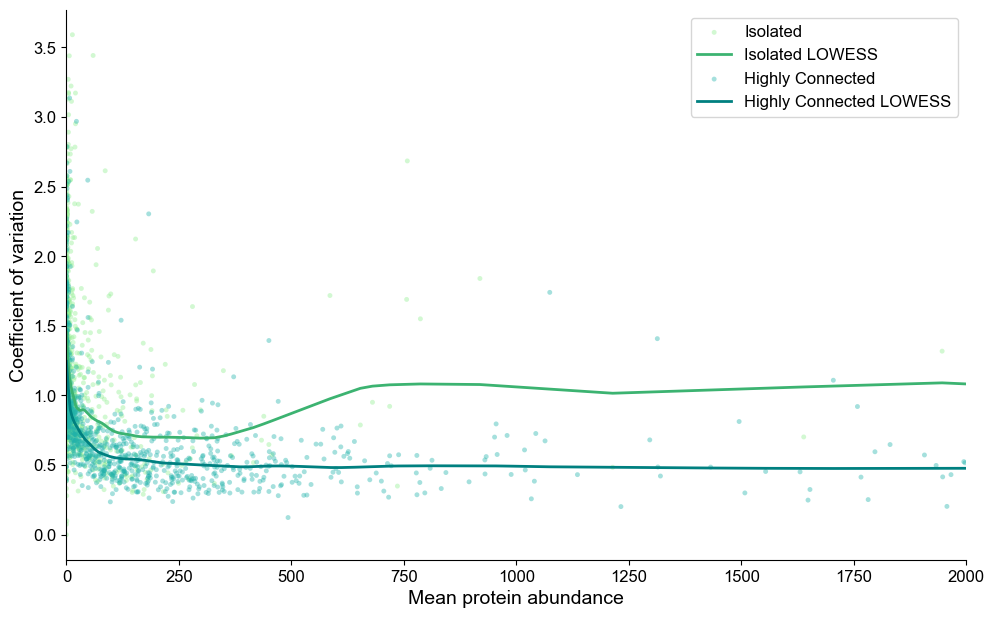

In [26]:
plt.figure(figsize=(9, 5.5))
plt.scatter(isolated_data['Mean'], isolated_data['CV'], label='Isolated', color='lightgreen', alpha=0.4, s=12.5, edgecolors='none')
plt.plot(isolated_lowess[:, 0], isolated_lowess[:, 1], color='mediumseagreen', label='Isolated LOWESS', alpha=1, linewidth=2)
plt.scatter(connected_data['Mean'], connected_data['CV'], label='Highly Connected', color='lightseagreen', alpha=0.4, s=12.5, edgecolors='none')
plt.plot(connected_lowess[:, 0], connected_lowess[:, 1], color='teal', label='Highly Connected LOWESS', alpha=1, linewidth=2)

plt.xlim(0, 2000)
plt.legend(prop=LEGENDFONT)
plt.xticks(**TICKPARAM)
plt.yticks(**TICKPARAM)
ax = plt.gca() 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

if SAVEFIG:
    plt.savefig("./figures/figure3c.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
else:
    plt.xlabel('Mean protein abundance', **LABELFONT)
    plt.ylabel('Coefficient of variation', **LABELFONT)
plt.show()

#### Cliques within TEC network

In [27]:
# Find all maximal cliques
cliques = sorted(nx.find_cliques(tec_graph_75), key=len, reverse=True)

# Find the largest one (by number of nodes)
largest_clique = cliques[0]
largest_clique_nodes = [tec_graph_75.nodes[node]['name'] for node in largest_clique]

In [28]:
for c in cliques:
    c_nodes = [tec_graph_75.nodes[node]['name'] for node in c]
    counter = 0
    for n in c_nodes:
        if 'RPL' in n or "RPS" in n:
            counter += 1
    percentage = counter / len(c_nodes) * 100
    # if percentage < 40:
    if percentage == 0:
        print(percentage, len(c_nodes))
        for n in c_nodes:
            print(n)
        break
    # print(f"Percentage: {counter / len(c_nodes) * 100}")

0.0 28
CCT3
XRCC6
EIF3I
ILF2
HNRNPF
EIF3D
CCT4
XRCC5
HSPA9
HNRNPK
HNRNPC
CCT5
CCT6A
PSMB1
CCT8
SERBP1
PGK1
CNBP
EIF3K
EIF4H
EIF3M
SLC25A3
EIF3H
HSPD1
NONO
RAN
EIF4A1
YWHAE


In [29]:
# get target and background genes for GO Enrichment analysis in EnrichR
# print("---TARGET GENES---")
# for node in largest_clique_nodes:
#     print(node)
# print("---BACKGROUND GENES---")
for node in tec_graph_75.nodes:
    print(tec_graph_75.nodes[node]['name'])

AAAS
METTL17
AAGAB
FOPNL
AARS1
ACLY
CCT3
CCT8
COPA
COPB2
COPG1
DDB1
DDX24
DDX5
DHX15
DHX9
EFTUD2
EIF3D
EIF3I
EIF4H
G3BP1
HADHA
HNRNPF
HNRNPH1
HNRNPR
HSPA9
IARS1
ILF2
KARS1
LAP3
MAT2A
NARS1
PGD
SF3B1
SF3B3
SND1
STIP1
THRAP3
XRCC5
XRCC6
AASDH
ZNF84
AASDHPPT
API5
CDC123
COPS4
COPS5
COX11
DARS1
DCAF13
DNM1L
EIF2S1
MRPS10
MRPS22
MRPS27
NAE1
PCMT1
PWP1
RMDN1
SNX2
SUGT1
UBA3
UBE2V2
VBP1
WDR43
ABCC10
ENGASE
PGAP6
ABCD3
ATL2
NUP133
OPA1
ABCE1
ACTR2
ACTR3
BCLAF1
BZW1
CAND1
CAPZA1
CCT2
CDC5L
COPB1
COPS2
CPSF2
CSE1L
DDX18
DDX21
DDX3X
DPM1
EIF3M
ELP2
EPRS1
ETF1
FAR1
FXR1
G3BP2
GFM1
GNL2
GTPBP4
HAT1
HIF1A
HSD17B4
HSPA4
LARS1
LTA4H
MARCHF7
MMADHC
MTREX
NAA15
NIFK
NMD3
NOL11
NUFIP2
PLRG1
POLR2B
PRPF40A
PSMA3
PSMC6
PSMD1
PSMD12
RARS1
RRN3
SEPTIN7
SMARCA5
SMU1
SUPT16H
SYNCRIP
TARS1
TNPO1
TOR2A
TXNRD1
U2SURP
VPS35
VPS4B
WDR36
XPO1
XRN2
YME1L1
ABCF1
SNW1
ABHD10
GPN3
LYPLAL1
NDUFA5
SUCLA2
ABHD11
DNAJC30
ABHD17A
REPIN1
SSBP4
ZNF672
ABHD17B
ARFIP1
PRKCI
ABHD18
CEP76
FASTKD3
ABL1
ATP13A2
INPPL1
LLGL1
MPRIP
MS

#### Figure 3d: Clustering visualization

In [30]:
connected_components = nx.connected_components(tec_graph_75)
connected_components = sorted(connected_components, key=len, reverse=True)
tec_cc_1 = connected_components[0]
tec_cc_1 = tec_graph_75.subgraph(tec_cc_1).copy()
tec_partition_1 = community_louvain.best_partition(tec_cc_1, weight='weight', randomize=False, random_state=42)

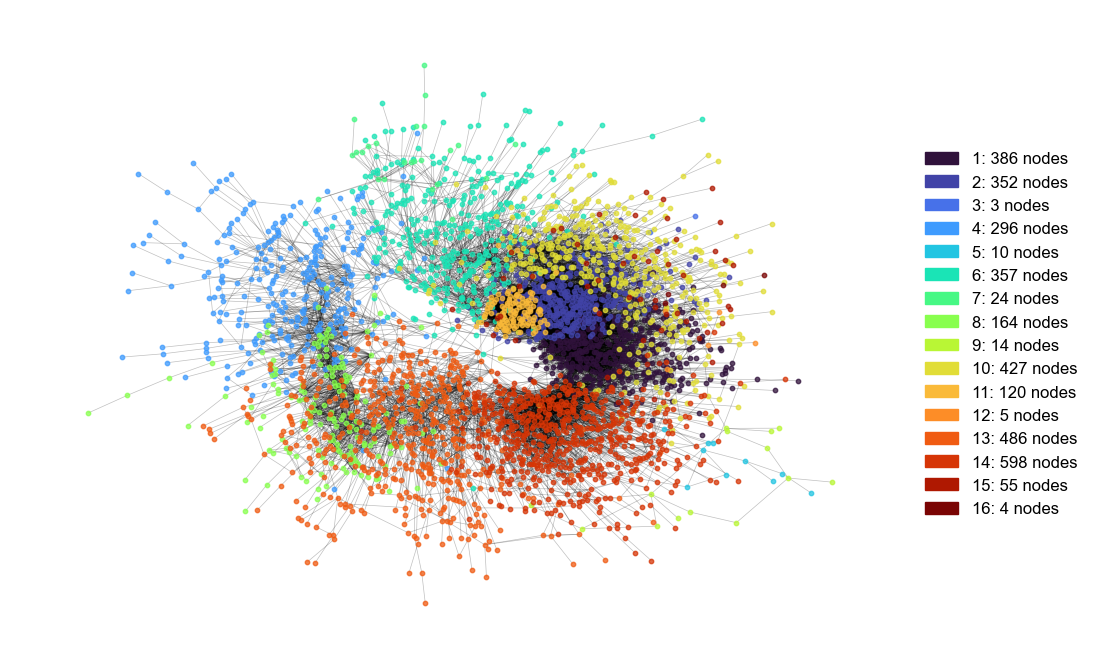

In [31]:
plt.figure(figsize=(9, 6.5))
pos = nx.kamada_kawai_layout(tec_cc_1)

unique_clusters = sorted(set(tec_partition_1.values()))
color_map = plt.get_cmap("turbo", len(unique_clusters)) 
legend_handles = [] # Store legend handles

for i, cluster in enumerate(unique_clusters):
    cluster_nodes = [node for node in tec_cc_1.nodes() if tec_partition_1[node] == cluster]
    nx.draw_networkx_nodes(
        tec_cc_1, pos, 
        nodelist=cluster_nodes, 
        node_color=[color_map(i)], 
        node_size=10, alpha=0.75
    )
    # Create a legend handle with the same color and a label with cluster size
    legend_label = f"{cluster+1}: {len(cluster_nodes)} nodes"
    patch = mpatches.Patch(color=color_map(i), label=legend_label)
    legend_handles.append(patch)

nx.draw_networkx_edges(tec_cc_1, pos, alpha=0.25, width=0.5)
plt.legend(
    handles=legend_handles, 
    loc="center left", 
    bbox_to_anchor=(1, 0.5), 
    frameon=False, 
    prop=LEGENDFONT
)

plt.box(False)
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
if SAVEFIG:
    plt.savefig("./figures/figure3d.pdf", format="pdf", bbox_inches='tight', pad_inches=0)
plt.show()

In [32]:
clustering_1 = dict()
for node, cluster in tec_partition_1.items():
    if cluster not in clustering_1:
        clustering_1[cluster] = []
    clustering_1[cluster].append(node)
for cluster, node_list in clustering_1.items():
    if len(node_list) == 10:
        for idx in node_list:
            print(idx2name[idx])

ALG8
DERL2
DRAM2
C5orf15
TMEM41B
YIPF5
GOLT1B
MSMO1
SC5D
SEC23A


#### Supplementary Table 5

In [33]:
genes = []
clusters = []
for node_id, cluster_id in tec_partition_1.items():
    genes.append(idx2name[node_id])
    clusters.append(int(cluster_id) + 1)

cluster_df = pd.DataFrame({
    "Gene name": genes,
    'Cluster id': clusters
})
cluster_df.head()

,Gene name,Cluster id
0,AARS1,1
1,ACLY,1
2,CCT3,2
3,CCT8,2
4,COPA,1
